### For Naga

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Applying Machine Learning/PS6')

Mounted at /content/drive


### For Fred

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/PS6')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


### Functions

In [3]:
import numpy as np
import csv
import string
import collections
import random
import nltk
nltk.download('stopwords')

# utility functions

def keyword_in_description(description, keyword):
  if description.find(keyword) != -1:
    return 1

  return 0

def load_data():
  # file = "/content/drive/MyDrive/Colab Notebooks/Applying Machine Learning/PS6/tables/loan_ridge_small.csv"
  file = "/content/drive/MyDrive/PS6/tables/loan_ridge_small.csv"
  X_raw = []
  y = []

  with open(file, 'rt', encoding='utf8') as f:
    dict_reader = csv.DictReader(f)

    for observation in dict_reader:
      y.append([int(observation['days_until_funded'])])
      observation.pop('days_until_funded', None)
      observation.pop('id', None)
      X_raw.append(observation)

    return (X_raw, y)

# added code to capture words/countries from most_common lists
def preprocessing(X_raw):
  X = []
  word_in_descriptions = []
  countries = []

  for observation in X_raw:
    description = observation['description_texts_en'].lower()

    for p in string.punctuation:
      description = description.replace(p, '')

    word_in_descriptions += description.split()
    countries.append(observation['location_country'].lower())

  word_counter = collections.Counter(word_in_descriptions)
  country_counter = collections.Counter(countries)
  stop_words = set(nltk.corpus.stopwords.words('english'))

  #creating lists for most frequent words/countries
  top_words = [word for word, _ in word_counter.most_common(75) if word not in stop_words]
  top_countries = [country for country, _ in country_counter.most_common(30)]

  for observation in X_raw:
    x = [float(observation['borrowers_borrower_gender']=='M')]

    for word, frequency in word_counter.most_common(75):
      if word not in stop_words:
        x.append(keyword_in_description(observation['description_texts_en'], word))

    for country, frequency in country_counter.most_common(30):
      x.append(float(observation['location_country']==country))

    x.append(float(observation["funded_amount"]))
    x.append(float(observation["terms_disbursal_amount"]))
    x.append(float(observation["repayment_term"]))

    X.append(x)

  return X, top_words, top_countries

def train_test_split(X, y, threshold):
    random.seed(32)

    X_train = []
    X_test = []
    y_train = []
    y_test = []

    for index in range(len(X)):
        z = random.uniform(0, 1)

        if z < threshold:
          X_train.append(X[index])
          y_train.append(y[index])

        else:
          X_test.append(X[index])
          y_test.append(y[index])

    X_train = np.matrix(X_train)
    y_train = np.array(y_train)
    X_test = np.matrix(X_test)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test

# prediction

def predict(X, beta):
  X = np.array(X)
  X = X[:, ~np.all(X == 0, axis=0)]
  beta = np.array(beta)
  y_hat = np.dot(X, beta)

  return y_hat

# calculate mse

def mean_squared_error(y_hat, y):
  mse = np.mean((y.flatten() - y_hat) ** 2)

  return mse

# regression functions

def add_ones(X):
  beta_zero_column = np.ones((X.shape[0], 1))
  X_ones = np.hstack((beta_zero_column, X))

  return X_ones

def ols(X, y):
    X = np.array(X)
    y = np.array(y)

    # delete zero rows
    X = X[~np.all(X == 0, axis=1)]

    # delete zero columns
    X = X[:, ~np.all(X == 0, axis=0)]

    # ols
    Xt = X.transpose()
    Xt_X = np.dot(Xt, X)
    Xt_X_inv = np.linalg.inv(Xt_X)
    Xt_X_inv_Xt = np.dot(Xt_X_inv, Xt)
    beta_hat = np.dot(Xt_X_inv_Xt, y)

    return beta_hat

def ridge(X, y, fLambda):
  X = np.array(X)
  y = np.array(y)

  # delete zero rows
  X = X[~np.all(X == 0, axis=1)]

  # delete zero columns
  X = X[:, ~np.all(X == 0, axis=0)]

  # ridge
  Xt = X.transpose()
  Xt_X = np.dot(Xt, X)
  lambda_I = fLambda * np.identity(X.shape[1])
  Xt_X_lambda_I_inv = np.linalg.inv(Xt_X + lambda_I)
  Xt_X_lambda_I_inv_Xt = np.dot(Xt_X_lambda_I_inv, Xt)
  beta_hat = np.dot(Xt_X_lambda_I_inv_Xt, y)

  return beta_hat

def recenter(X, y):
    X = X - np.mean(X, 0)
    y = y - np.mean(y)

    return X, y

# new function to get the cols removed, got code from ols
def get_removed_col_indices(X):
    X = np.array(X)
    original_cols = np.arange(X.shape[1])
    non_zero_cols = ~np.all(X  == 0, axis=0)
    removed_cols = original_cols[~non_zero_cols]
    return removed_cols, original_cols

# new function to remove features
def remove_features(feat_list, removed_cols):
  return [feature for i, feature in enumerate(feat_list) if i not in removed_cols]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Explore Created Functions

In [4]:
X_raw, y = load_data()

# preprossesing also returns the most commmon lists now
X, top_words, top_countries = preprocessing(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.5)
X_train_ones = add_ones(X_train)
X_test_ones = add_ones(X_test)

# list with all the features
feat_list = ['gender'] + top_words + top_countries + ['funded_amount', 'terms_disbursal_amount', 'repayment_term']
# print(f'feature list {feat_list}')

print('X_raw', X_raw)
print('number of obs', len(X))
print('number of features', len(X[0]))
rank = np.linalg.matrix_rank(X)
print("rank:", rank)
print()
print('X_train after ones are added:')
print(X_train_ones)
print('X_train:', X_train_ones.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test_ones.shape)
print('y_test:', y_test.shape)

X_raw [{'': '2399', 'borrowers_borrower_gender': 'F', 'description_texts_en': "With a loan of 10,600 pesos, Yiskella will be able to buy shampoo, conditioner, hair-care products, and women's underwear for her customers. She decided to begin this business when her son was born, and he is now 5 years old. She is a single mother, and knowing that she would not have support to raise her son, she decided to open her own beauty salon, since she had worked up until then as an employee. \n\nHer son is in kindergarten, and in the afternoons she has the opportunity to be with him and help him with his homework, since the beauty salon operates from her house. Yiskella wants to save to buy a plot of land where she will begin, little by little, the construction of her own house.", 'status': '', 'funded_amount': '275', 'paid_amount': '', 'terms_disbursal_amount': '10600.0', 'loan_amount': '275', 'activity': 'Beauty Salon', 'sector': 'Services', 'location_country': 'Dominican Republic', 'location_tow

### Creating a list of features

In [7]:
dropped_cols_train, original_cols_train = get_removed_col_indices(X_train)


# optional validation
# print(f'number of features {len(original_cols_train)}')
# print('number of features', len(X[0]))
#print(f'removed indices for training data {dropped_cols_train}')


final_cols_train = remove_features(feat_list, dropped_cols_train)

# manually adding intercept
final_cols_train_intercept = ['intercept'] + final_cols_train
print(f'final features for training data {final_cols_train_intercept}')

removed indices for training data [38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 65 66 67]
final features for training data ['intercept', 'gender', 'business', 'loan', 'years', 'children', 'buy', 'income', 'family', 'married', 'old', 'help', 'work', 'sells', 'two', 'lives', 'husband', 'living', 'able', 'use', 'also', 'support', 'purchase', 'customers', 'one', 'works', 'group', 'selling', 'hopes', 'school', 'working', 'requesting', 'needs', 'products', 'time', 'future', 'small', 'sell', 'rice', 'funded_amount', 'terms_disbursal_amount', 'repayment_term']


# Part III. Ridge Regression

## 1) Implement the ridge function in the stencil code. This function should calculate and return β using given input observations (X), their corresponding y values and a  value.

## 2) Report the value of the  vector that is produced by running the ridge regression with λ=0 on your entire dataset. Indicate which independent variable corresponds with which i.

### a) When λ=0, what method does your estimate correspond with?

## **Ridge with λ=0 and intercept**

In [9]:
# Doing Ridge lambda=0 with intercept column

beta_hat_ridge_0_ones = ridge(X_train_ones, y_train, 0)

print(beta_hat_ridge_0_ones)
print(len(beta_hat_ridge_0_ones))

[[-5.30594727e-01]
 [ 3.99386574e+00]
 [-1.33097650e+00]
 [ 2.63101708e+00]
 [-8.46914128e-01]
 [-7.76760229e-01]
 [ 9.30412483e-01]
 [-7.28530616e-01]
 [-1.24061372e+00]
 [ 2.19297891e+00]
 [-6.02599672e-01]
 [-3.26533628e-01]
 [-3.30772642e-01]
 [ 2.74023810e+00]
 [-8.59820742e-02]
 [-1.01304462e+00]
 [-1.91085538e+00]
 [ 1.01096233e-01]
 [ 1.90517284e+00]
 [-5.76959932e-01]
 [-1.02707728e+00]
 [ 2.64510061e-01]
 [ 1.38408101e+00]
 [-6.25745082e-02]
 [-1.46753906e+00]
 [ 8.88319780e-01]
 [-3.76239600e-01]
 [ 1.82164540e+00]
 [-8.49272285e-01]
 [ 2.74313651e+00]
 [ 1.64871188e-01]
 [ 1.74912514e+00]
 [-1.02291770e+00]
 [ 1.86522648e+00]
 [-7.68809200e-01]
 [ 3.31860347e-01]
 [ 1.27360168e+00]
 [-1.30330453e+00]
 [ 1.46333756e+00]
 [ 1.50169487e-03]
 [-1.88186293e-07]
 [ 1.44484752e-01]]
42


In [10]:
#formatting for submission

beta_hat_ridge_0_int_rounded = beta_hat_ridge_0_ones.round(2)
beta_hat_ridge_ones_labeled = np.column_stack((final_cols_train_intercept, beta_hat_ridge_0_int_rounded))
beta_hat_ridge_labeled_rounded = np.column_stack((final_cols_train_intercept, beta_hat_ridge_0_int_rounded))


#print(beta_hat_ridge_ones_labeled)
print(beta_hat_ridge_labeled_rounded)

[['intercept' '-0.53']
 ['gender' '3.99']
 ['business' '-1.33']
 ['loan' '2.63']
 ['years' '-0.85']
 ['children' '-0.78']
 ['buy' '0.93']
 ['income' '-0.73']
 ['family' '-1.24']
 ['married' '2.19']
 ['old' '-0.6']
 ['help' '-0.33']
 ['work' '-0.33']
 ['sells' '2.74']
 ['two' '-0.09']
 ['lives' '-1.01']
 ['husband' '-1.91']
 ['living' '0.1']
 ['able' '1.91']
 ['use' '-0.58']
 ['also' '-1.03']
 ['support' '0.26']
 ['purchase' '1.38']
 ['customers' '-0.06']
 ['one' '-1.47']
 ['works' '0.89']
 ['group' '-0.38']
 ['selling' '1.82']
 ['hopes' '-0.85']
 ['school' '2.74']
 ['working' '0.16']
 ['requesting' '1.75']
 ['needs' '-1.02']
 ['products' '1.87']
 ['time' '-0.77']
 ['future' '0.33']
 ['small' '1.27']
 ['sell' '-1.3']
 ['rice' '1.46']
 ['funded_amount' '0.0']
 ['terms_disbursal_amount' '-0.0']
 ['repayment_term' '0.14']]


In [11]:
#Note this doesn't have an intercept column included

X_train_center, y_train_center = recenter(X_train, y_train)
beta_hat_ridge_0_center = ridge(X_train_center, y_train_center, 0)
print(beta_hat_ridge_0_center)
print(len(beta_hat_ridge_0_center))

[[ 3.99386574e+00]
 [-1.33097650e+00]
 [ 2.63101708e+00]
 [-8.46914128e-01]
 [-7.76760229e-01]
 [ 9.30412483e-01]
 [-7.28530616e-01]
 [-1.24061372e+00]
 [ 2.19297891e+00]
 [-6.02599672e-01]
 [-3.26533628e-01]
 [-3.30772642e-01]
 [ 2.74023810e+00]
 [-8.59820742e-02]
 [-1.01304462e+00]
 [-1.91085538e+00]
 [ 1.01096233e-01]
 [ 1.90517284e+00]
 [-5.76959932e-01]
 [-1.02707728e+00]
 [ 2.64510061e-01]
 [ 1.38408101e+00]
 [-6.25745082e-02]
 [-1.46753906e+00]
 [ 8.88319780e-01]
 [-3.76239600e-01]
 [ 1.82164540e+00]
 [-8.49272285e-01]
 [ 2.74313651e+00]
 [ 1.64871188e-01]
 [ 1.74912514e+00]
 [-1.02291770e+00]
 [ 1.86522648e+00]
 [-7.68809200e-01]
 [ 3.31860347e-01]
 [ 1.27360168e+00]
 [-1.30330453e+00]
 [ 1.46333756e+00]
 [ 1.50169487e-03]
 [-1.88186293e-07]
 [ 1.44484752e-01]]
41


In [12]:
# Formatting for submission

beta_hat_ridge_0_center_rounded = beta_hat_ridge_0_center.round(2)
beta_hat_ridge_center_labeled = np.column_stack((final_cols_train, beta_hat_ridge_0_center))
beta_hat_ridge_center_labeled_rounded = np.column_stack((final_cols_train, beta_hat_ridge_0_center_rounded))


#print(beta_hat_ridge_labeled)
print(beta_hat_ridge_center_labeled_rounded)

[['gender' '3.99']
 ['business' '-1.33']
 ['loan' '2.63']
 ['years' '-0.85']
 ['children' '-0.78']
 ['buy' '0.93']
 ['income' '-0.73']
 ['family' '-1.24']
 ['married' '2.19']
 ['old' '-0.6']
 ['help' '-0.33']
 ['work' '-0.33']
 ['sells' '2.74']
 ['two' '-0.09']
 ['lives' '-1.01']
 ['husband' '-1.91']
 ['living' '0.1']
 ['able' '1.91']
 ['use' '-0.58']
 ['also' '-1.03']
 ['support' '0.26']
 ['purchase' '1.38']
 ['customers' '-0.06']
 ['one' '-1.47']
 ['works' '0.89']
 ['group' '-0.38']
 ['selling' '1.82']
 ['hopes' '-0.85']
 ['school' '2.74']
 ['working' '0.16']
 ['requesting' '1.75']
 ['needs' '-1.02']
 ['products' '1.87']
 ['time' '-0.77']
 ['future' '0.33']
 ['small' '1.27']
 ['sell' '-1.3']
 ['rice' '1.46']
 ['funded_amount' '0.0']
 ['terms_disbursal_amount' '-0.0']
 ['repayment_term' '0.14']]


## 3) Using recentered variables, re-train a ridge regression model with λ=1, and:

## **Recentered Ridge with λ=1**

In [14]:
beta_hat_ridge_1 = ridge(X_train, y_train, 1)
print(beta_hat_ridge_1)
print(len(beta_hat_ridge_1))

[[ 3.88995119e+00]
 [-1.34191853e+00]
 [ 2.39317038e+00]
 [-8.18184198e-01]
 [-6.79586192e-01]
 [ 8.65230003e-01]
 [-7.09040168e-01]
 [-1.16487140e+00]
 [ 2.10779230e+00]
 [-5.55284096e-01]
 [-3.07490530e-01]
 [-3.23776513e-01]
 [ 2.54082362e+00]
 [-1.01285306e-01]
 [-9.31929443e-01]
 [-1.84137605e+00]
 [ 1.07516246e-01]
 [ 1.86617686e+00]
 [-5.77195754e-01]
 [-9.91968373e-01]
 [ 2.34703490e-01]
 [ 1.29841292e+00]
 [-1.08635571e-02]
 [-1.37297102e+00]
 [ 8.02719045e-01]
 [-4.17533261e-01]
 [ 1.61513579e+00]
 [-8.55968879e-01]
 [ 2.57809871e+00]
 [ 1.38872061e-01]
 [ 1.69168932e+00]
 [-9.85104615e-01]
 [ 1.76573477e+00]
 [-7.11436293e-01]
 [ 3.23666460e-01]
 [ 1.22357440e+00]
 [-1.10049199e+00]
 [ 1.40207287e+00]
 [ 1.48569169e-03]
 [-1.95817782e-07]
 [ 1.17219005e-01]]
41


### a) Use your model to calculate the value of days_until_funded that your model predicts for each loan in both the training set and the testing set.

In [17]:
# training data days_until_funded prediction

beta_hat_ridge_1_center = ridge(X_train, y_train, 1)
y_hat_train_1 = predict(X_train, beta_hat_ridge_1_center)
print(y_hat_train_1)
print(len(y_hat_train_1))

[[ 3.51322991e+00]
 [ 3.17474622e+00]
 [ 3.16349577e+00]
 [ 6.24615530e+00]
 [ 5.37329304e+00]
 [ 2.40639170e+00]
 [ 2.52845186e+00]
 [ 4.15605459e+00]
 [ 3.97532755e+00]
 [ 4.84993948e+00]
 [ 2.00352822e+00]
 [-2.09821189e+00]
 [ 9.70390860e+00]
 [ 6.66984142e+00]
 [ 2.70293259e+00]
 [ 3.97466060e+00]
 [ 5.60934749e+00]
 [ 5.26205023e+00]
 [ 5.18618052e+00]
 [ 1.69582028e+00]
 [ 3.86796994e+00]
 [ 1.65478355e+00]
 [ 3.73217161e+00]
 [ 6.24450267e+00]
 [ 2.52175931e+00]
 [ 3.58716300e+00]
 [ 6.62781705e+00]
 [ 7.30431060e-01]
 [ 6.62099218e+00]
 [ 6.38134168e+00]
 [ 8.16329342e-01]
 [ 1.06288580e+01]
 [ 6.53742024e-01]
 [ 6.84830164e+00]
 [ 8.70569621e+00]
 [ 4.60139575e+00]
 [ 9.22407435e+00]
 [ 5.31970988e+00]
 [ 1.04553474e+01]
 [ 2.75831361e-02]
 [ 9.81809238e+00]
 [ 5.96402435e+00]
 [ 1.17008575e+01]
 [ 6.61929732e+00]
 [ 4.34148367e+00]
 [ 8.75290504e+00]
 [ 1.24082505e+01]
 [ 4.50701417e+00]
 [-6.46989110e-02]
 [ 7.77393858e-01]
 [ 2.40671511e+00]
 [ 2.61215879e+00]
 [ 3.1835058

In [ ]:
# testing data days_until_funded prediction

y_hat_test_1 = predict(X_test, beta_hat_ridge_1_center)
print(y_hat_test_1)
print(len(y_hat_test_1))

[[ 4.99268199]
 [ 4.12258962]
 [ 3.40398518]
 [ 1.73531428]
 [ 1.45754832]
 [ 2.17554842]
 [ 1.62192733]
 [ 1.94824375]
 [ 0.25349579]
 [ 1.9007939 ]
 [ 4.46859343]
 [ 7.15276668]
 [ 3.12345015]
 [11.49511093]
 [ 7.2159384 ]
 [ 5.67596618]
 [ 3.51817437]
 [ 8.27497444]
 [ 4.31560316]
 [ 5.19685469]
 [ 3.20440208]
 [ 3.87179002]
 [ 3.19696207]
 [ 7.6214422 ]
 [ 3.64022494]
 [ 5.91828974]
 [ 1.5304794 ]
 [ 6.60384821]
 [ 0.96402649]
 [ 2.24424942]
 [ 8.29771247]
 [ 5.33660698]
 [ 6.81804144]
 [ 6.84693876]
 [ 3.28415805]
 [ 8.08448851]
 [ 3.68664855]
 [ 3.57124624]
 [ 5.35288645]
 [ 2.42813113]
 [ 1.64032251]
 [ 7.88912483]
 [ 1.8066597 ]
 [ 4.34472522]
 [ 1.96082518]
 [ 6.33036178]
 [ 2.95429526]
 [-2.01345079]
 [16.51779912]
 [ 4.48367218]
 [-0.75496441]
 [-0.44169904]
 [ 0.23620575]
 [ 3.12294536]
 [ 4.27029222]
 [ 2.60589315]
 [ 3.0850842 ]
 [ 7.4122262 ]
 [ 2.84365525]
 [ 1.4289997 ]
 [ 8.86826657]
 [ 1.4986906 ]
 [ 7.18281816]
 [ 6.41836257]
 [ 1.1515613 ]
 [11.35333063]
 [ 7.07443

### b) Using the predictions and actual values, calculate the In-Sample (training) and Out-Sample (testing) mean squared errors. Report the errors you obtained. How do these compare to the training and test errors from OLS?


In [ ]:
mse_in_sample = mean_squared_error(y_hat_train_1, y_train)
print('MSE in sample:', mse_in_sample)

MSE in sample: 54.986902942608175


In [ ]:
mse_out_sample = mean_squared_error(y_hat_test_1, y_test)
print('MSE out sample:', mse_out_sample)

MSE out sample: 73.57023534312346


## 4) Chooseing a λ

### a) Select 5 – 10 variables from all generated variables, plot how each i for these variables changes as  increases.

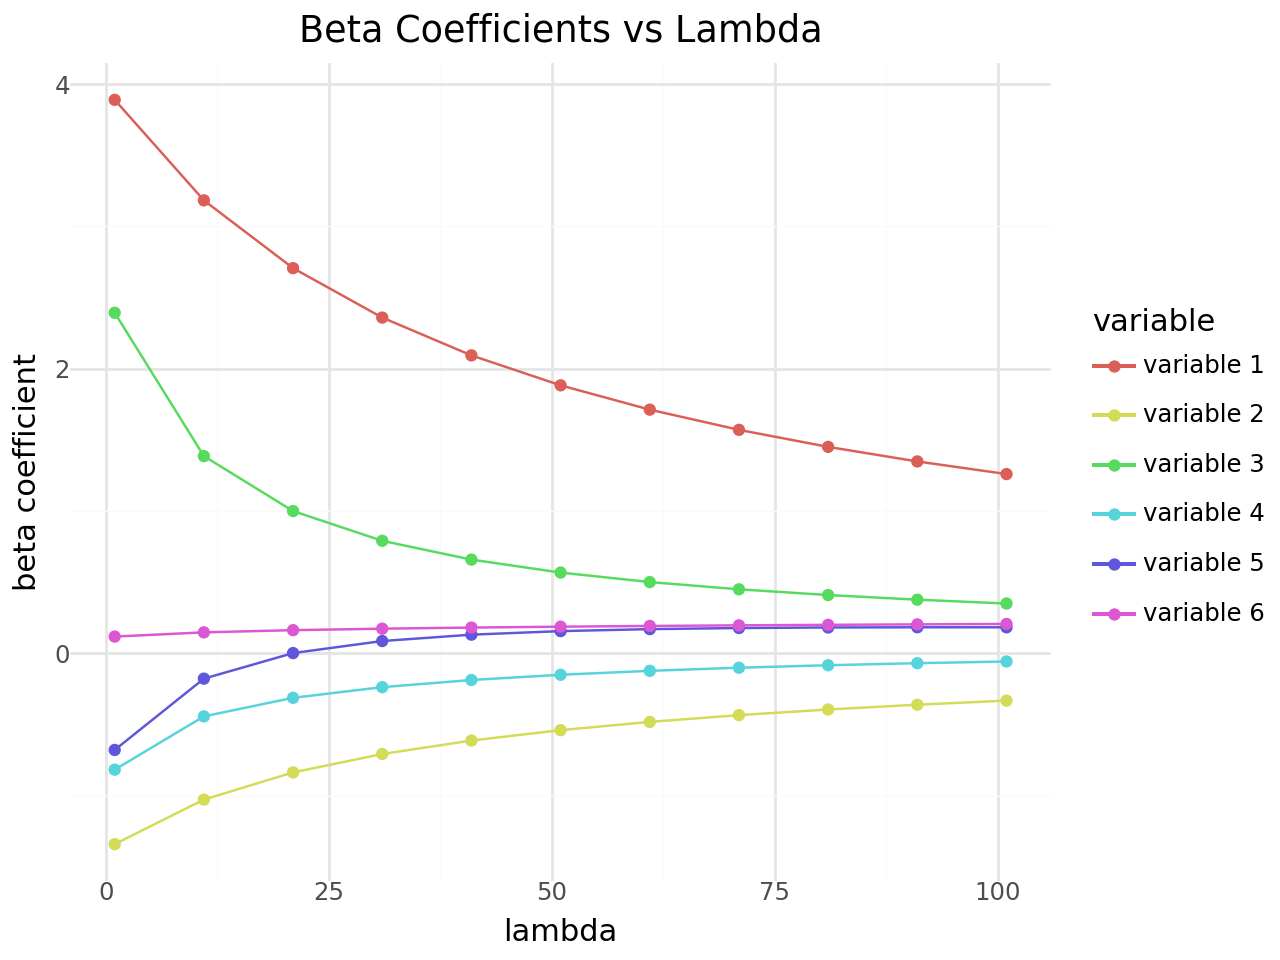

In [18]:
import pandas as pd
import plotnine as p9

def beta_lambda_plot(beta1, beta2, beta3, beta4, beta5, beta6):
    df = pd.DataFrame({
        'lambda': range(1, 102, 10),
        'variable 1': [b.item() for b in beta1],
        'variable 2': [b.item() for b in beta2],
        'variable 3': [b.item() for b in beta3],
        'variable 4': [b.item() for b in beta4],
        'variable 5': [b.item() for b in beta5],
        'variable 6': [b.item() for b in beta6]
    })

    df_melted = df.melt(
        id_vars='lambda',
        var_name='variable',
        value_name='beta coefficient'
    )

    plot = (
        p9.ggplot(df_melted, p9.aes(x='lambda', y='beta coefficient', color='variable'))
        + p9.geom_line()
        + p9.geom_point()
        + p9.labs(title="Beta Coefficients vs Lambda", x="lambda", y="beta coefficient")
        + p9.theme_minimal()
    )

    return plot

beta_hat_var1_list = []
beta_hat_var2_list = []
beta_hat_var3_list = []
beta_hat_var4_list = []
beta_hat_var5_list = []
beta_hat_var41_list = []

for i in range(1, 102, 10):
    beta_hat_ridge = ridge(X_train, y_train, i)
    beta_hat_var1_list.append(beta_hat_ridge[0])
    beta_hat_var2_list.append(beta_hat_ridge[1])
    beta_hat_var3_list.append(beta_hat_ridge[2])
    beta_hat_var4_list.append(beta_hat_ridge[3])
    beta_hat_var5_list.append(beta_hat_ridge[4])
    beta_hat_var41_list.append(beta_hat_ridge[40])

beta_lambda_plot(beta_hat_var1_list,
                 beta_hat_var2_list,
                 beta_hat_var3_list,
                 beta_hat_var4_list,
                 beta_hat_var5_list,
                 beta_hat_var41_list)

### b) Plot how the MSE in both the training and test data changes as  increase. Comment on the results you obtain.

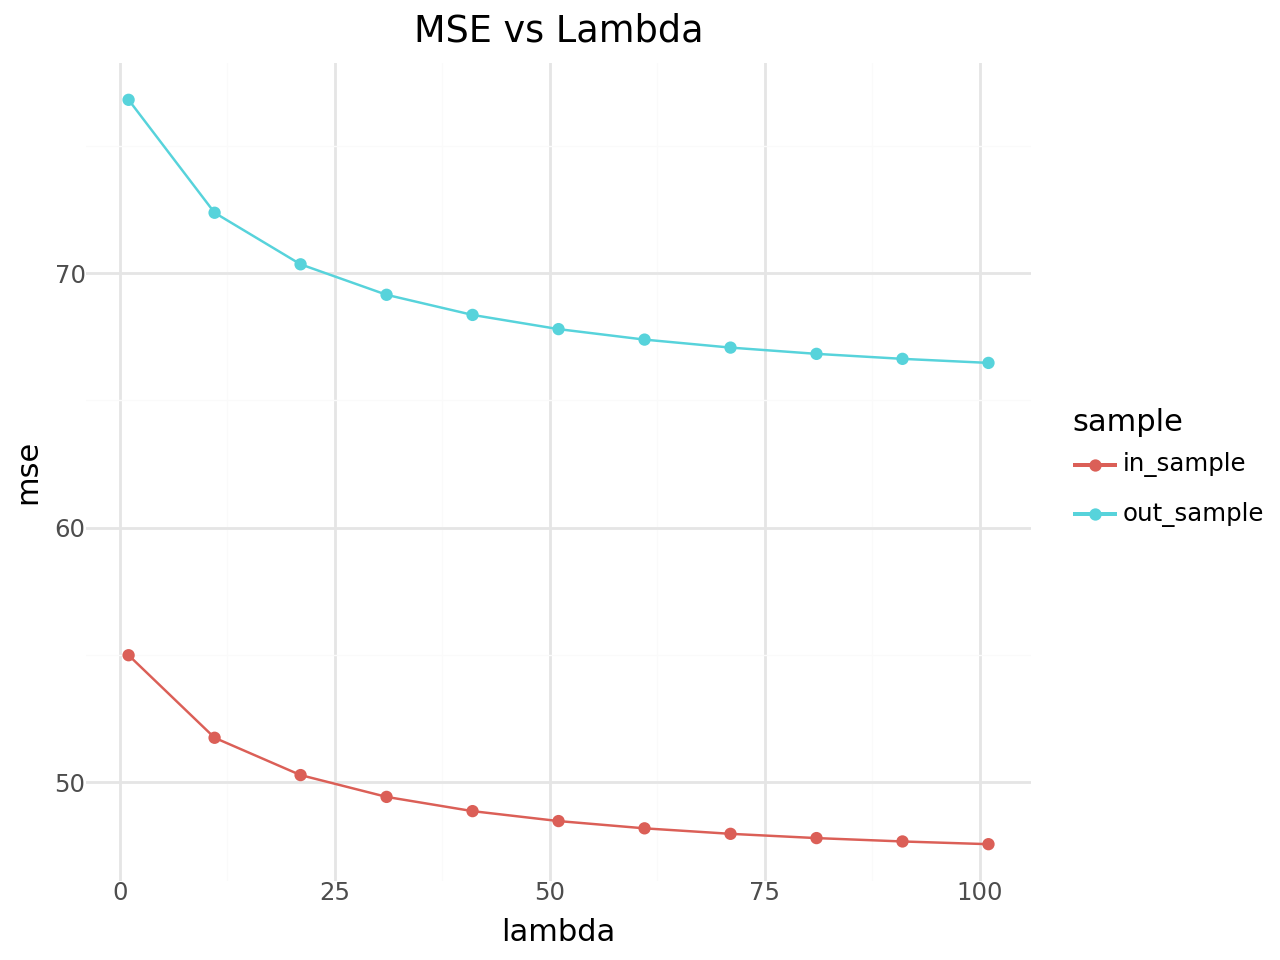

In [ ]:
import pandas as pd
import plotnine as p9

def mse_lambda_plot(mse_in_sample, mse_out_sample):
    df = pd.DataFrame(
        {
        'lambda': range(1, 102, 10),
        'in_sample': mse_in_sample,
        'out_sample': mse_out_sample,
    }
        )

    df_melted = df.melt(
        id_vars='lambda',
        var_name='sample',
        value_name='mse'
    )

    plot = (
        p9.ggplot(df_melted, p9.aes(x='lambda', y='mse', color='sample'))
        + p9.geom_line()
        + p9.geom_point()
        + p9.labs(title="MSE vs Lambda", x="lambda", y="mse")
        + p9.theme_minimal()
    )

    return plot

mse_in_sample_list = []

for i in range(1, 102, 10):
  beta_hat_ridge_center = ridge(X_train, y_train, i)
  y_hat_train = predict(X_train, beta_hat_ridge_center)
  mse_in_sample = mean_squared_error(y_hat_train, y_train)
  mse_in_sample_list.append(mse_in_sample)

# print('MSE in sample:', mse_in_sample_list)

mse_out_sample_list = []

for i in range(1, 102, 10):
  beta_hat_ridge_center_test = ridge(X_test, y_test, i)
  y_hat_test = predict(X_test, beta_hat_ridge_center_test)
  mse_out_sample = mean_squared_error(y_hat_test, y_test)
  mse_out_sample_list.append(mse_out_sample)

# print('MSE out sample:', mse_out_sample_list)

mse_lambda_plot(mse_in_sample_list, mse_out_sample_list)